In [1]:
#TAREA 2 INTELIGENCIA COMPUTACIONAL

#Bastian Garces

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import sklearn.preprocessing
import sklearn.svm 
import sklearn.model_selection
import sklearn.metrics

In [3]:
from google.colab import files
uploaded = files.upload()

Saving magic04.data to magic04.data
Saving magic04.names to magic04.names


In [4]:
ls

magic04.data  magic04.names  sample_data/


In [5]:
# ACTIVIDAD 1

names = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1','fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class'] #Vector con el nombre de cada columna
df = pd.read_csv('magic04.data',names=names)

In [7]:
# ACTIVIDAD 2

#Primero separamos el dataframe en hadron y no-hadron
H = df[df['class'] == 'h'].reset_index(drop=True)
NH = df[df['class'] == 'g'].reset_index(drop=True)

#Volvemos a desordenar los conjuntos obtenidos 
H_des = H.sample(frac=1).reset_index(drop=True)
NH_des = NH.sample(frac=1).reset_index(drop=True)

Cantidad = int(3000) #Cantidad de muestras de cada tipo deseadas
#Seleccionamos 3000 muestras de cada uno
MuestrasH = H_des.sample(n=Cantidad).reset_index(drop=True)
MuestrasNH = NH_des.sample(n=Cantidad).reset_index(drop=True)

#Unimos ambos dataframes
Muestreo = pd.concat([MuestrasH,MuestrasNH]).reset_index(drop=True)

In [8]:
#Actividad 3

#Puntos de corte
CorEntre = int(Cantidad*0.6)
CorVali = int(Cantidad*0.8)

#Conjuntos
Entrena = pd.concat([MuestrasH.iloc[:CorEntre,:],MuestrasNH.iloc[:CorEntre,:]]).reset_index(drop=True)
Vali = pd.concat([MuestrasH.iloc[CorEntre:CorVali,:],MuestrasNH.iloc[CorEntre:CorVali,:]]).reset_index(drop=True)
Prue = pd.concat([MuestrasH.iloc[CorVali:,:],MuestrasNH.iloc[CorVali:,:]]).reset_index(drop=True)


In [9]:
#Actividad 4

#Creamos el StandardScaler 
scaler = sklearn.preprocessing.StandardScaler()

#Entrenamos el scaler
scaler.fit(Entrena.iloc[:,:10])

#Aplicamos el scaler a los distintos conjuntos
S_Entrena = scaler.transform(Entrena.iloc[:,:10])
S_Vali = scaler.transform(Vali.iloc[:,:10])
S_Prue = scaler.transform(Prue.iloc[:,:10])

#Obtenemos la columna clase de cada conjunto 
#cambiamos los 'g' por 0 y los 'h' por 1
#y luego se pasan a array
Entrena_class = Entrena.iloc[:,10].replace({'g' : 0,'h' : 1}).to_numpy()
Vali_class = Vali.iloc[:,10].replace({'g' : 0,'h' : 1}).to_numpy()
Prue_class = Prue.iloc[:,10].replace({'g' : 0,'h' : 1}).to_numpy()



In [10]:
#Actividad 5

#Creamos el SVM lineal
SVM_lin = sklearn.svm.SVC(kernel='linear',probability=False)

#Creamos lista de parametros C que probara el Gridsearch
param_lin = {'C': [0.01,0.1,1,10,100]}
grid_lin = sklearn.model_selection.GridSearchCV(SVM_lin,param_lin,cv=5)

#Entrenamos con el test de entrenamiento
grid_lin.fit(S_Entrena,Entrena_class)
print(' ')

In [11]:
#Actividad 6

#Evaluamos sobre el conjunto de validacion normalizado
predict_lin = grid_lin.predict(S_Vali) #<-- De aca obtenemos las predicciones del clasificador

#Generamos las matrices de confusion
#La version normalizada:
Matrix_lin_N = sklearn.metrics.confusion_matrix(Vali_class,predict_lin,normalize='true')
#La version sin normalizar:
Matrix_lin_NoN = sklearn.metrics.confusion_matrix(Vali_class,predict_lin)
print('La matriz de confusion normalizada es:')
print(Matrix_lin_N)
print('La matriz de confusion sin normalizar es:')
print(Matrix_lin_NoN)


La matriz de confusion normalizada es:
[[0.84833333 0.15166667]
 [0.26       0.74      ]]
La matriz de confusion sin normalizar es:
[[509  91]
 [156 444]]


El area bajo la curva ROC es de:  0.8583749999999999


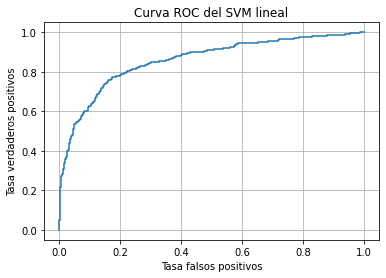

In [12]:
#Actividad 7

#Obtenemos la funcion de decision
deci_lin = grid_lin.decision_function(S_Vali)

#Obtenemos la curva ROC
TFP_lin,TVP_lin,threshold_lin = sklearn.metrics.roc_curve(Vali_class,deci_lin)

#Obtenemos el area bajo la curva
Area_lin = sklearn.metrics.auc(TFP_lin,TVP_lin)
print('El area bajo la curva ROC es de: ',str(Area_lin))

#Graficamos la curva ROC
plt.plot(TFP_lin,TVP_lin)
plt.title('Curva ROC del SVM lineal')
plt.xlabel('Tasa falsos positivos')
plt.ylabel('Tasa verdaderos positivos')
plt.grid()

El average precision score es:  0.871233289450808


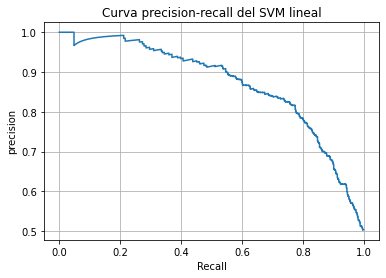

In [13]:
#Actividad 8

#Obtenemos la curva de precision-recall
P_lin, R_lin, threshold_lin_PR =  sklearn.metrics.precision_recall_curve(Vali_class,deci_lin)

#Obtenemos el average precision
prom_lin = sklearn.metrics.average_precision_score(Vali_class,deci_lin)
print('El average precision score es: ',str(prom_lin))

#Graficamos la curva precision-recall
plt.plot(R_lin,P_lin)
plt.title('Curva precision-recall del SVM lineal')
plt.xlabel('Recall')
plt.ylabel('precision')
plt.grid()

La matriz de confusion normalizada es:
[[0.93666667 0.06333333]
 [0.35166667 0.64833333]]
La matriz de confusion sin normalizar es:
[[562  38]
 [211 389]]
El area bajo la curva ROC es de:  0.8813361111111112
El average precision score es:  0.8984564038286467


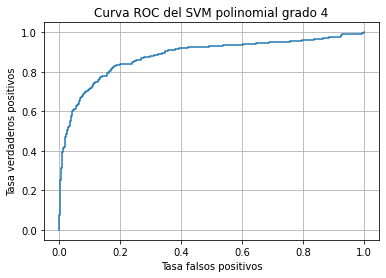

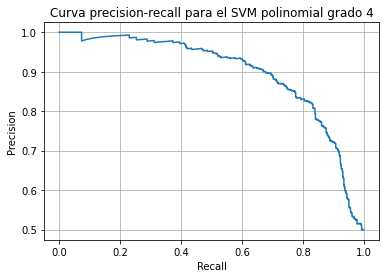

In [14]:
#Actividad 9.1 - Primer SVM polinomial

#Creamos el SVM polinomial de grado 4
SVM_pol4 = sklearn.svm.SVC(kernel='poly',degree=4,probability=False)

#Creamos diccionario de parametros que usara la grilla para ambos clasificadores
param_pol = {'C' : [0.01,0.1,1,10],
             'gamma' : [0.0001,0.001,0.01,0.1]}
grid_pol4 = sklearn.model_selection.GridSearchCV(SVM_pol4,param_pol,cv=5)

#Entrenamos el grid con el test de entrenamiento
grid_pol4.fit(S_Entrena,Entrena_class)

#Vemos las predicciones que hacen los clasificadores 
predict_pol4 = grid_pol4.predict(S_Vali)

#Obtenemos las matrices de confusion:
#Version normalizada:
Matrix_pol4_N = sklearn.metrics.confusion_matrix(Vali_class,predict_pol4,normalize='true')
#Version no normalizada:
Matrix_pol4_NoN = sklearn.metrics.confusion_matrix(Vali_class,predict_pol4)
print('La matriz de confusion normalizada es:')
print(Matrix_pol4_N)
print('La matriz de confusion sin normalizar es:')
print(Matrix_pol4_NoN)

#Obtenemos la funcion de decision
deci_pol4 = grid_pol4.decision_function(S_Vali)

#Obtenemos los parametros de la curva ROC
TFP_pol4,TVP_pol4,threshold_pol4 = sklearn.metrics.roc_curve(Vali_class,deci_pol4)

#Obtenemos el area bajo la curva ROC
Area_pol4 = sklearn.metrics.auc(TFP_pol4,TVP_pol4)
print('El area bajo la curva ROC es de: ',str(Area_pol4))

#Graficamos las curvas ROC
plt.figure(1)
plt.title('Curva ROC del SVM polinomial grado 4')
plt.xlabel('Tasa falsos positivos')
plt.ylabel('Tasa verdaderos positivos')
plt.grid()
plt.plot(TFP_pol4,TVP_pol4)

#Obtenemos los parametros de la curva de precision-recall
P_pol4, R_pol4, threshold_pol4_PR = sklearn.metrics.precision_recall_curve(Vali_class,deci_pol4)

#Obtenemos el average precision
prom_pol4 = sklearn.metrics.average_precision_score(Vali_class,deci_pol4)
print('El average precision score es: ',str(prom_pol4))

#Graficamos la curva precision-recall
plt.figure(2)
plt.title('Curva precision-recall para el SVM polinomial grado 4')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.plot(R_pol4,P_pol4)

La matriz de confusion normalizada es:
[[0.96  0.04 ]
 [0.515 0.485]]
La matriz de confusion sin normalizar es:
[[576  24]
 [309 291]]
El area bajo la curva ROC es de:  0.8449722222222222
El average precision score es:  0.8660174983043489


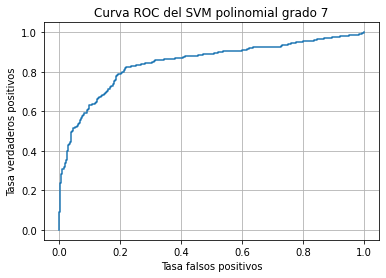

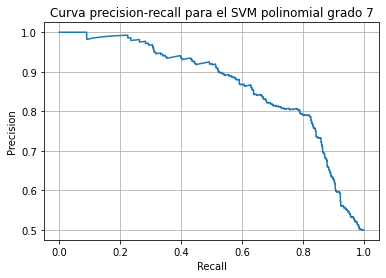

In [15]:
#Actividad 9.2 - Segundo SVM polinomial

#Creamos el SVM polinomial de grado 7
SVM_pol7 = sklearn.svm.SVC(kernel='poly',degree=7,probability=False)

#Grilla del clasificador
grid_pol7 = sklearn.model_selection.GridSearchCV(SVM_pol7,param_pol,cv=5)

#Entrenamos el grid con el conjunto de entrenamiento
grid_pol7.fit(S_Entrena,Entrena_class)

#Vemos las predicciones que hace el clasificador
predict_pol7 = grid_pol7.predict(S_Vali)

#Obtenemos las matrices de confusion para el clasificador
#Version normalizada:
Matrix_pol7_N = sklearn.metrics.confusion_matrix(Vali_class,predict_pol7,normalize='true')
#Version no normalizada:
Matrix_pol7_NoN = sklearn.metrics.confusion_matrix(Vali_class,predict_pol7)
print('La matriz de confusion normalizada es:')
print(Matrix_pol7_N)
print('La matriz de confusion sin normalizar es:')
print(Matrix_pol7_NoN)

#Obtenemos la funcion de decision del clasificador
deci_pol7 = grid_pol7.decision_function(S_Vali)

#Obtenemos los parametros de la curva ROC
TFP_pol7,TVP_pol7,threshold_pol7 = sklearn.metrics.roc_curve(Vali_class,deci_pol7)

#Obtenemos el area bajo la curva ROC
Area_pol7 = sklearn.metrics.auc(TFP_pol7,TVP_pol7)
print('El area bajo la curva ROC es de: ',str(Area_pol7))

#Graficamos la curva ROC
plt.figure(1)
plt.plot(TFP_pol7,TVP_pol7)
plt.title('Curva ROC del SVM polinomial grado 7')
plt.xlabel('Tasa falsos positivos')
plt.ylabel('Tasa verdaderos positivos')
plt.grid()

#Obtenemos los parametros de la curva de precision-recall
P_pol7, R_pol7, threshold_pol7_PR = sklearn.metrics.precision_recall_curve(Vali_class,deci_pol7)

#Obtenemos el average precision
prom_pol7 = sklearn.metrics.average_precision_score(Vali_class,deci_pol7)
print('El average precision score es: ',str(prom_pol7))

#Graficamos la curva precision-recall
plt.figure(2)
plt.plot(R_pol7,P_pol7)
plt.title('Curva precision-recall para el SVM polinomial grado 7')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()

La matriz de confusion normalizada es:
[[0.91       0.09      ]
 [0.18666667 0.81333333]]
La matriz de confusion sin normalizar es:
[[546  54]
 [112 488]]
El area bajo la curva ROC es de:  0.9280666666666666
El average precision score es:  0.9407432944318636


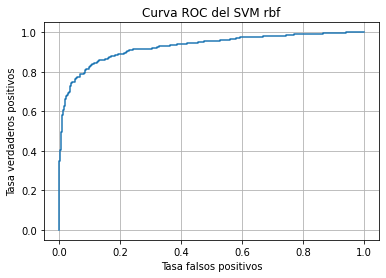

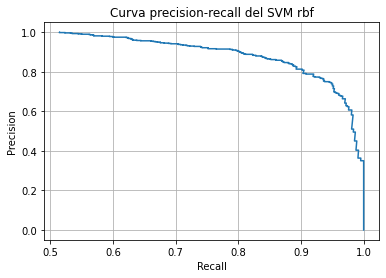

In [16]:
#Actividad 10

#Creamos el SVM rbf
SVM_rbf = sklearn.svm.SVC(kernel='rbf',probability=False)

#Grilla del clasificador
param_rbf = {'C' : [0.01,0.1,1,10],
             'gamma' : [0.0001,0.001,0.01,0.1]}
grid_rbf = sklearn.model_selection.GridSearchCV(SVM_rbf,param_rbf,cv=5)

#Entrenamos el grid con el conjunto de entrenamiento
grid_rbf.fit(S_Entrena,Entrena_class)

#Obtenemos las predicciones que hace el clasificador
predict_rbf = grid_rbf.predict(S_Vali)

#Obtenemos las matrices de confusion
#La version normalizada:
Matrix_rbf_N = sklearn.metrics.confusion_matrix(Vali_class,predict_rbf,normalize='true')
#Version no normalizada:
Matrix_rbf_NoN = sklearn.metrics.confusion_matrix(Vali_class,predict_rbf)
print('La matriz de confusion normalizada es:')
print(Matrix_rbf_N)
print('La matriz de confusion sin normalizar es:')
print(Matrix_rbf_NoN)

#Obtenemos la funcion de decision
deci_rbf = grid_rbf.decision_function(S_Vali)

#Obtenemos los parametros de la curva ROC
TFP_rbf, TVP_rbf, threshold_rbf = sklearn.metrics.roc_curve(Vali_class,deci_rbf)

#Area bajo la curva ROC
Area_rbf = sklearn.metrics.auc(TFP_rbf,TVP_rbf)
print('El area bajo la curva ROC es de: ',str(Area_rbf))

#Obtenemos la curva ROC
plt.figure(1)
plt.title('Curva ROC del SVM rbf')
plt.xlabel('Tasa falsos positivos')
plt.ylabel('Tasa verdaderos positivos')
plt.grid()
plt.plot(TFP_rbf,TVP_rbf)

#Obtenemos los parametros para la curva precision-recall
R_rbf,P_rbf,threshold_rbf_PR = sklearn.metrics.precision_recall_curve(Vali_class,deci_rbf)

#Obtenemos el average precision score
prom_rbf = sklearn.metrics.average_precision_score(Vali_class,deci_rbf)
print('El average precision score es: ',str(prom_rbf))

#Graficamos la curva precision-recall
plt.figure(2)
plt.title('Curva precision-recall del SVM rbf')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.plot(R_rbf,P_rbf)

In [17]:
#Actividad 11

#Obtenemos las predicciones que hacen los clasificadores
predict_lin_Prue = grid_lin.predict(S_Prue)
predict_pol4_Prue = grid_pol4.predict(S_Prue)
predict_pol7_Prue = grid_pol7.predict(S_Prue)
predict_rbf_Prue = grid_rbf.predict(S_Prue)

#Obtenemos las matrices de confusion que hacen los clasificadores
#La version normalizada:
Matrix_lin_Prue_N = sklearn.metrics.confusion_matrix(Prue_class,predict_lin_Prue,normalize='true')
Matrix_pol4_Prue_N = sklearn.metrics.confusion_matrix(Prue_class,predict_pol4_Prue,normalize='true')
Matrix_pol7_Prue_N = sklearn.metrics.confusion_matrix(Prue_class,predict_pol7_Prue,normalize='true')
Matrix_rbf_Prue_N = sklearn.metrics.confusion_matrix(Prue_class,predict_rbf_Prue,normalize='true')
#Version no normalizada:
Matrix_lin_Prue_NoN = sklearn.metrics.confusion_matrix(Prue_class,predict_lin_Prue)
Matrix_pol4_Prue_NoN = sklearn.metrics.confusion_matrix(Prue_class,predict_pol4_Prue)
Matrix_pol7_Prue_NoN = sklearn.metrics.confusion_matrix(Prue_class,predict_pol7_Prue)
Matrix_rbf_Prue_NoN = sklearn.metrics.confusion_matrix(Prue_class,predict_rbf_Prue)

#Obtenemos la funcion de decision de los clasificadores
deci_lin_Prue = grid_lin.decision_function(S_Prue)
deci_pol4_Prue = grid_pol4.decision_function(S_Prue)
deci_pol7_Prue = grid_pol7.decision_function(S_Prue)
deci_rbf_Prue = grid_rbf.decision_function(S_Prue)

#Obtenemos los parametros de la curva ROC de los clasificadores
TFP_lin_Prue, TVP_lin_Prue, threshold_lin_Prue = sklearn.metrics.roc_curve(Prue_class,deci_lin_Prue)
TFP_pol4_Prue, TVP_pol4_Prue, threshold_pol4_Prue = sklearn.metrics.roc_curve(Prue_class,deci_pol4_Prue)
TFP_pol7_Prue, TVP_pol7_Prue, threshold_pol7_Prue = sklearn.metrics.roc_curve(Prue_class,deci_pol7_Prue)
TFP_rbf_Prue, TVP_rbf_Prue, threshold_rbf_Prue = sklearn.metrics.roc_curve(Prue_class,deci_rbf_Prue)

#Area bajo la curva ROC de cada clasificador
Area_lin_Prue = sklearn.metrics.auc(TFP_lin_Prue,TVP_lin_Prue)
Area_pol4_Prue = sklearn.metrics.auc(TFP_pol4_Prue,TVP_pol4_Prue)
Area_pol7_Prue = sklearn.metrics.auc(TFP_pol7_Prue,TVP_pol7_Prue)
Area_rbf_Prue = sklearn.metrics.auc(TFP_rbf_Prue,TVP_rbf_Prue)

#Obtenemos los parametros para la curva precision-recall de los clasificadores
R_lin_Prue,P_lin_Prue,threshold_lin_Prue_PR = sklearn.metrics.precision_recall_curve(Prue_class,deci_lin_Prue)
R_pol4_Prue,P_pol4_Prue,threshold_pol4_Prue_PR = sklearn.metrics.precision_recall_curve(Prue_class,deci_pol4_Prue)
R_pol7_Prue,P_pol7_Prue,threshold_pol7_Prue_PR = sklearn.metrics.precision_recall_curve(Prue_class,deci_pol7_Prue)
R_rbf_Prue,P_rbf_Prue,threshold_rbf_Prue_PR = sklearn.metrics.precision_recall_curve(Prue_class,deci_rbf_Prue)

#Obtenemos el average precision score de los clasificadores
prom_lin_Prue = sklearn.metrics.average_precision_score(Prue_class,deci_lin_Prue)
prom_pol4_Prue = sklearn.metrics.average_precision_score(Prue_class,deci_pol4_Prue)
prom_pol7_Prue = sklearn.metrics.average_precision_score(Prue_class,deci_pol7_Prue)
prom_rbf_Prue = sklearn.metrics.average_precision_score(Prue_class,deci_rbf_Prue)


Metricas del SVM lineal sobre el conjunto de Prueba

La matriz de confusion normalizada es:
[[0.83       0.17      ]
 [0.31166667 0.68833333]]
La matriz de confusion sin normalizar es:
[[498 102]
 [187 413]]
El area bajo la curva ROC es de:  0.8313222222222223
El average precision score es:  0.836780302581633


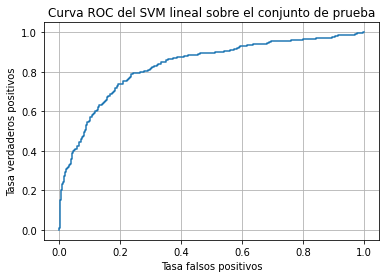

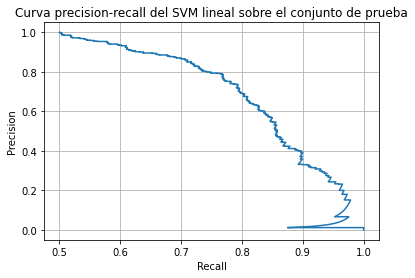

In [18]:
#Actividad 11 - Exhibicion de las metricas para el SVM lineal
print('')
print('Metricas del SVM lineal sobre el conjunto de Prueba')
print('')
#Matrices de confusion
print('La matriz de confusion normalizada es:')
print(Matrix_lin_Prue_N)
print('La matriz de confusion sin normalizar es:')
print(Matrix_lin_Prue_NoN)

#Area bajo la curva ROC
print('El area bajo la curva ROC es de: ',str(Area_lin_Prue))

#Curva ROC
plt.figure(1)
plt.title('Curva ROC del SVM lineal sobre el conjunto de prueba')
plt.xlabel('Tasa falsos positivos')
plt.ylabel('Tasa verdaderos positivos')
plt.grid()
plt.plot(TFP_lin_Prue,TVP_lin_Prue)

#Obtenemos el average precision score
print('El average precision score es: ',str(prom_lin_Prue))

#Graficamos la curva precision-recall
plt.figure(2)
plt.title('Curva precision-recall del SVM lineal sobre el conjunto de prueba')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.plot(R_lin_Prue,P_lin_Prue)


Metricas del SVM polinomial de grado 4 sobre el conjunto de Prueba

La matriz de confusion normalizada es:
[[0.93666667 0.06333333]
 [0.37666667 0.62333333]]
La matriz de confusion sin normalizar es:
[[562  38]
 [226 374]]
El area bajo la curva ROC es de:  0.8922249999999999
El average precision score es:  0.8952073757489647


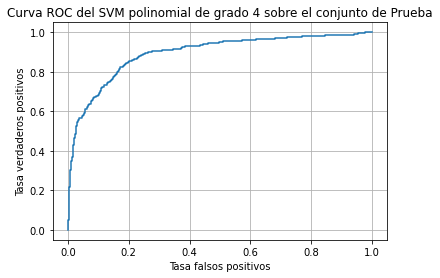

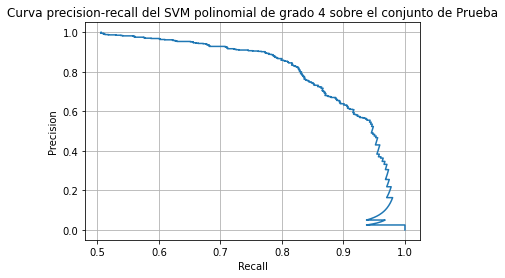

In [19]:
#Actividad 11 - Exhibicion de las metricas para el SVM polinomial grado 4
print('')
print('Metricas del SVM polinomial de grado 4 sobre el conjunto de Prueba')
print('')
#Matrices de confusion
print('La matriz de confusion normalizada es:')
print(Matrix_pol4_Prue_N)
print('La matriz de confusion sin normalizar es:')
print(Matrix_pol4_Prue_NoN)

#Area bajo la curva ROC
print('El area bajo la curva ROC es de: ',str(Area_pol4_Prue))

#Curva ROC
plt.figure(1)
plt.title('Curva ROC del SVM polinomial de grado 4 sobre el conjunto de Prueba')
plt.xlabel('Tasa falsos positivos')
plt.ylabel('Tasa verdaderos positivos')
plt.grid()
plt.plot(TFP_pol4_Prue,TVP_pol4_Prue)

#Obtenemos el average precision score
print('El average precision score es: ',str(prom_pol4_Prue))

#Graficamos la curva precision-recall
plt.figure(2)
plt.title('Curva precision-recall del SVM polinomial de grado 4 sobre el conjunto de Prueba')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.plot(R_pol4_Prue,P_pol4_Prue)


Metricas del SVM polinomial de grado 7 sobre el conjunto de Prueba

La matriz de confusion normalizada es:
[[0.95333333 0.04666667]
 [0.565      0.435     ]]
La matriz de confusion sin normalizar es:
[[572  28]
 [339 261]]
El area bajo la curva ROC es de:  0.8400944444444445
El average precision score es:  0.8487988434354651


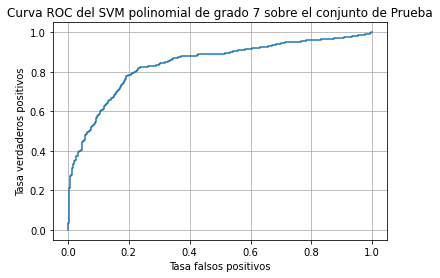

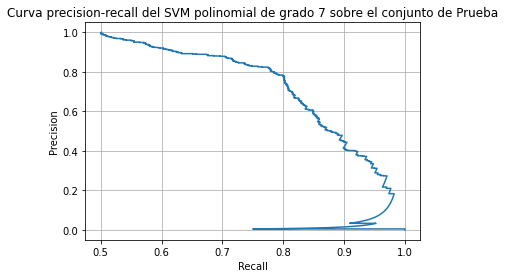

In [20]:
#Actividad 11 - Exhibicion de las metricas para el SVM polinomial grado 7
print('')
print('Metricas del SVM polinomial de grado 7 sobre el conjunto de Prueba')
print('')
#Matrices de confusion
print('La matriz de confusion normalizada es:')
print(Matrix_pol7_Prue_N)
print('La matriz de confusion sin normalizar es:')
print(Matrix_pol7_Prue_NoN)

#Area bajo la curva ROC
print('El area bajo la curva ROC es de: ',str(Area_pol7_Prue))

#Curva ROC
plt.figure(1)
plt.title('Curva ROC del SVM polinomial de grado 7 sobre el conjunto de Prueba')
plt.xlabel('Tasa falsos positivos')
plt.ylabel('Tasa verdaderos positivos')
plt.grid()
plt.plot(TFP_pol7_Prue,TVP_pol7_Prue)

#Obtenemos el average precision score
print('El average precision score es: ',str(prom_pol7_Prue))

#Graficamos la curva precision-recall
plt.figure(2)
plt.title('Curva precision-recall del SVM polinomial de grado 7 sobre el conjunto de Prueba')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.plot(R_pol7_Prue,P_pol7_Prue)


Metricas del SVM rbf sobre el conjunto de Prueba

La matriz de confusion normalizada es:
[[0.90666667 0.09333333]
 [0.20833333 0.79166667]]
La matriz de confusion sin normalizar es:
[[544  56]
 [125 475]]
El area bajo la curva ROC es de:  0.9239583333333332
El average precision score es:  0.9329882178565811


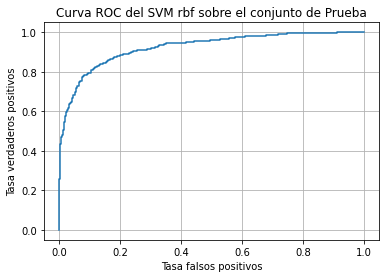

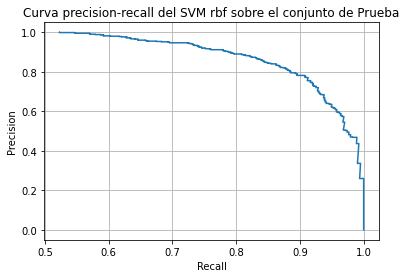

In [21]:
#Actividad 11 - Exhibicion de las metricas para el SVM polinomial grado 7
print('')
print('Metricas del SVM rbf sobre el conjunto de Prueba')
print('')
#Matrices de confusion
print('La matriz de confusion normalizada es:')
print(Matrix_rbf_Prue_N)
print('La matriz de confusion sin normalizar es:')
print(Matrix_rbf_Prue_NoN)

#Area bajo la curva ROC
print('El area bajo la curva ROC es de: ',str(Area_rbf_Prue))

#Curva ROC
plt.figure(1)
plt.title('Curva ROC del SVM rbf sobre el conjunto de Prueba')
plt.xlabel('Tasa falsos positivos')
plt.ylabel('Tasa verdaderos positivos')
plt.grid()
plt.plot(TFP_rbf_Prue,TVP_rbf_Prue)

#Obtenemos el average precision score
print('El average precision score es: ',str(prom_rbf_Prue))

#Graficamos la curva precision-recall
plt.figure(2)
plt.title('Curva precision-recall del SVM rbf sobre el conjunto de Prueba')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.plot(R_rbf_Prue,P_rbf_Prue)